## Mini Project 1: The Travelling Salesman 

In this notebook, you will find the guidelines to complete your mini-project 1 on the travelling salesman problem. 


As illustrated in the lecture, simulated annealing is a probablistic approach used for finding a solution to an optimization problem. In this mini project you implement
a simulated annealing Python code applied to the Travelling Salesman Problem (TSP).

Typically, the TSP is an optimization problem that seeks to find the shortest path passing through every city exactly once. In our example the TSP path is defined to start and end in the same city (so the path is a closed loop).

### before leaving the room, if anything is not clear with the starting example code, the setup of the problem, or the general content of the report then please speak to a TA for clarification


## Overview of the Mini project

In this project we will :

  0. construct the `simulated_annealing` function 
  0. write a pairwise swap move  
  0. Complete a temperature `schedule` function to define the temperature profile
  0. Use the obtained algorithm to solve the TSP on a generated map of random points
  0. Extend this method to the realistic case of US capitals on a map
  0. Answer the open questions at the end of the notebook


### Import the Numpy and Matplotlib modules

As we practiced in the past notebooks, we import here the relevant modules. 






In [77]:
import numpy as np  
import numpy.random as random  
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import math

%matplotlib inline



### Python and matplotlib versions

Some students have reported issues when running the notebook examples with python 3.10. Please document here and in the report the version of python and matplotlib you are using on your system. 

In [78]:
import sys
import matplotlib 
print("Python version: {}".format(sys.version))
print("Matplotlib version: {}".format(matplotlib.__version__))

Python version: 3.11.5 (main, Sep 11 2023, 08:19:27) [Clang 14.0.6 ]
Matplotlib version: 3.7.2



### List of US capitals

To base our approach on a realistic question, we use here the map services and data available from U.S. Geological Survey, National Geospatial Program.
If interested, see https://www.usgs.gov/information-policies-and-instructions/usgs-visual-identity-system for further information.

We provide on KEATS both a map (map.png) and a list of the US capitals
(capitals.json). Please save those two files at the same location as this Python Notebook. 
We will make use in this notebook of a few additional modules that will help with
showing the path on the US map. 

These are not key to the understanding of the assignment, but will be helpful in visualising your results.

We start by importing the US map as an image file:


In [79]:
import json
import copy

from IPython.core.interactiveshell import InteractiveShell

InteractiveShell.ast_node_interactivity = "all"

map = mpimg.imread("map.png")  




We load the file "capitals.json", e.g. the list of US cities, into a list named `capitals_list` : 







In [80]:
# List of 30 US state capitals and corresponding coordinates on the map

with open('capitals.json', 'r') as capitals_file:
    capitals = json.load(capitals_file)
    
    
capitals_list = list(capitals.items())

capitals_list = [(c[0], tuple(c[1])) for c in capitals_list]
# if this [ ... for ... in ... ] syntax is unfamilier look up python list comprehension 

print(capitals_list)

print("example : ")

print(capitals_list[0])



[('Oklahoma City', (392.8, 356.4)), ('Montgomery', (559.6, 404.8)), ('Saint Paul', (451.6, 186.0)), ('Trenton', (698.8, 239.6)), ('Salt Lake City', (204.0, 243.2)), ('Columbus', (590.8, 263.2)), ('Austin', (389.2, 448.4)), ('Phoenix', (179.6, 371.2)), ('Hartford', (719.6, 205.2)), ('Baton Rouge', (489.6, 442.0)), ('Salem', (80.0, 139.2)), ('Little Rock', (469.2, 367.2)), ('Richmond', (673.2, 293.6)), ('Jackson', (501.6, 409.6)), ('Des Moines', (447.6, 246.0)), ('Lansing', (563.6, 216.4)), ('Denver', (293.6, 274.0)), ('Boise', (159.6, 182.8)), ('Raleigh', (662.0, 328.8)), ('Atlanta', (585.6, 376.8)), ('Madison', (500.8, 217.6)), ('Indianapolis', (548.0, 272.8)), ('Nashville', (546.4, 336.8)), ('Columbia', (632.4, 364.8)), ('Providence', (735.2, 201.2)), ('Boston', (738.4, 190.8)), ('Tallahassee', (594.8, 434.8)), ('Sacramento', (68.4, 254.0)), ('Albany', (702.0, 193.6)), ('Harrisburg', (670.8, 244.0))]
example : 
('Oklahoma City', (392.8, 356.4))





A path connecting a set of cities can be defined as a simple list of these cities:

`path = [capitals_list[0],capitals_list[1],capitals_list[4]]`

In this example, we connect the first, second and fifth cities of the list (St Paul, Little Rock,
Salt Lake City).

We now define below a function `show path` that will allow you to overlay the chosen path on the map of the USA, and test your implementation of the TSP on a realistic example.


In [81]:
def coord(path):
        """Strip the city name from each element of the path list and return
        a list of tuples containing only pairs of xy coordinates for the
        cities. For example,
            [("Atlanta", (585.6, 376.8)), ...] -> [(585.6, 376.8), ...]
        """
        _, coord = path
        return coord

def coords(path):
        """Strip the city name from each element of the path list and return
        a list of tuples containing only pairs of xy coordinates for the
        cities. For example,
            [("Atlanta", (585.6, 376.8)), ...] -> [(585.6, 376.8), ...]
        """
        _, coords = zip(*path)
        return coords
    
def show_path(path_, starting_city, w=35, h=15):
    """Plot a TSP path overlaid on a map of the US States & their capitals."""
    path=coords(path_) 
    x, y = list(zip(*path))
    
    _, (x0, y0) = starting_city
    
    plt.imshow(map)
    plt.plot(x0, y0, 'y*', markersize=15)  # y* = yellow star for starting point
    plt.plot(x + x[:1], y + y[:1])  # include the starting point at the end of path
    plt.axis("off")
    fig = plt.gcf()
    fig.set_size_inches([w, h])
    


As an example, we show the path defined above:




[('Oklahoma City', (392.8, 356.4)), ('Montgomery', (559.6, 404.8)), ('Salt Lake City', (204.0, 243.2))]


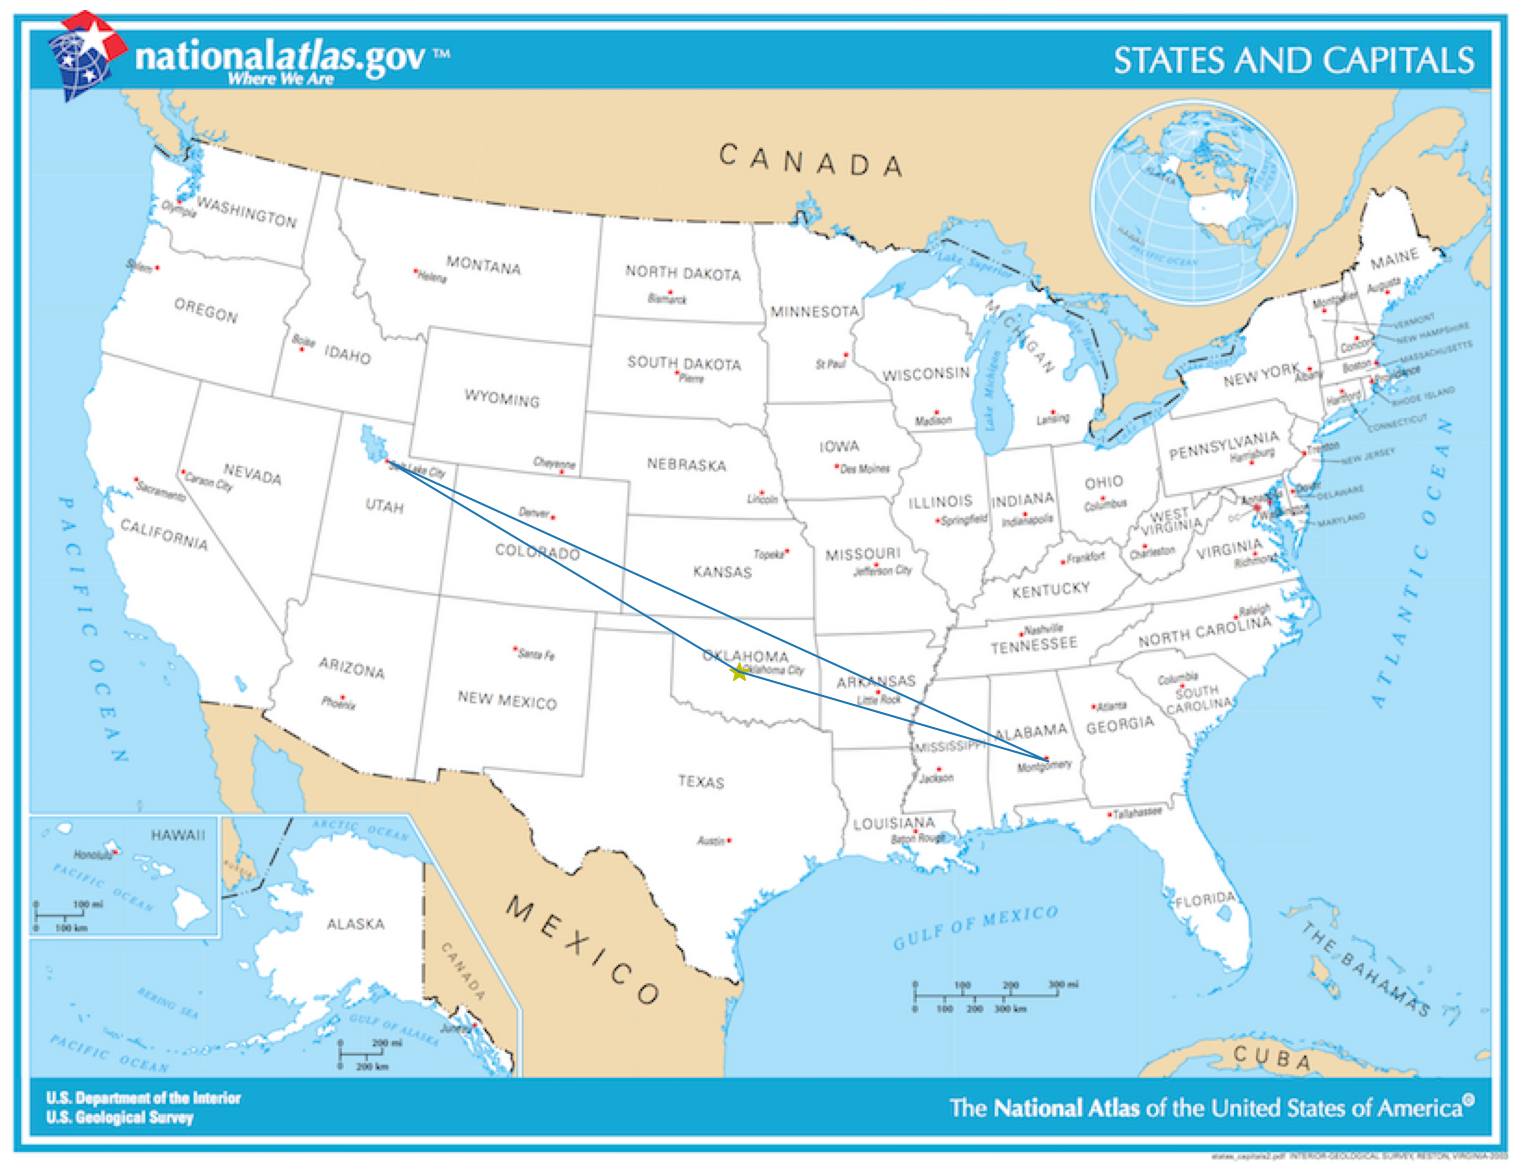

In [82]:
path = [capitals_list[0],capitals_list[1],capitals_list[4]]

print(path)

show_path(path,capitals_list[0])

## Simulated Annealing -- The algorithm

Here, we want to implement the main loop of the simulated annealing algorithm. 

We will repeatedly swap pairs of cities and consider accepting or rejecting such
a modification, in accordance to a probability function $P$ :

$$ P = e^{ - \left( d_{new} - d_{old}  \right) / T } $$

where $d_{new}$ and $d_{old}$ are respectively the new and old overall path length, and $T$ is a "temperature". Note of course that $T$ is not a physical temperature, but a control parameter that determines how likely we are to accept or reject this move. 

The simulated annealing algorithm is a version of a stochastic hill climbing (the top of the hill is the shortest path length)
where some downhill moves are allowed. Downhill moves (moves that lead to a longer path length) are accepted readily
early in the annealing schedule and then less often as time goes on. 

In other words, we will ask you to start accepting and rejecting moves with a high temperature,
and slowly reduce the temperature present in the simulation as times goes on. This is called a temperature schedule. 

The schedule input determines the value of the temperature T as a function of time. 










## Problem 1 :  Define the Temperature Schedule

The most common temperature schedule is simple exponential decay: 

$$T(t) = \alpha^t T_0$$

In most cases, the valid range for temperature $T_0$ can be very high (e.g., 1e8 or higher), and the _decay parameter_ $\alpha$ should be close to, but less than 1.0 (e.g., 0.95 or 0.99).  Think about the ways these parameters effect the simulated annealing function.  Try experimenting with both parameters to see how it changes runtime and the quality of solutions. 

You can also experiment with other schedule functions -- linear, quadratic, etc.  Think about the ways that changing the form of the temperature schedule changes the behavior and results of the simulated annealing function.

Remember to include the code (as new code blocks and plot outputs) and results (as markdown blocks) from these investigations--this applies throughout the report. If it is not included we can't give marks for it.

In the following cell, define a function that takes the time $t$ as an argument, and returns
the temperature as an output. Use default values for the parameters $\alpha$ and $T_0$, which should also be arguments of the function.






In [83]:

#to FILL


def temperature(t, alpha = 0.95, t0 = 1e+8):
    temp = t0 * (alpha ** t)
    return temp




## Problem 2 : Define a starting random path

In order to use simulated annealing we need to build a representation of the problem domain.  The choice of representation can have a significant impact on the performance of simulated annealing and other optimization techniques.  Since the TSP deals with a close loop that visits each city in a list once, we will represent each city by a tuple containing the city name and its position specified by an (x,y) location on a grid. The path is defined as the sequence generated by traveling from each city in the list to the next in order.

Note that in the example above, `capital_cities` is a list that contains the cities, both their names and their coordinates. 

For example, a chosen path could be:

`path_start = [ capitals_list[0], capitals_list[2], capitals_list[5] ]` 

The associated geographic coordinates can be obtained by the function `coords( city_list  )`, which returns a list of the coordinates for the path, or similarly, by the function `coord( city )`, which returns the coordinates of a single city.





In [8]:
print("coordinate of the city capital_cities[2] : ")

print( coord ( capitals_list[2] ) )  

print(len(capitals_list))

coordinate of the city capital_cities[2] : 
(451.6, 186.0)
30


Define in the cell below a function which generates a random path that connects 8 cities, and passes only once by each cities





In [84]:

#TO FILL 

def random_path(n, citytotal):
    pathindex = []
    path = []
    
    while len(path) < n:
        rcity = np.random.randint(0, citytotal, dtype=int)
        
        if rcity not in pathindex:
            pathindex.append(rcity)
            path.append(capitals_list[rcity])
    
    return path



## Problem 3 : Pair-wise exchange

In order to apply the simulated annealing algorithm, we will need to perform pair-wise exchange of 
cities along the path. Define in the cell below a function that takes a path as an argument, and returns another path, where two given cities have been swapped. 

For this function, you might have to copy a list in Python.

Note that the simple operation: `list2 = list1` will not formally operate a copy of list1 to a new object list2 (if you modify list2, it will also modify list1, the two object are related).

To create a new independent list as an actual copy, use instead:

`list2=list1.copy()` 

Hint: pay attention to the cyclic nature of the problem. Here the last city is connected to the first one. You might use the modulo function in Python :

` x % y ` where x modulo y returns the remainder of the division of x by y. 

This funciton should accept as an input a given path, and return as an output a new path variable,
independent from the input. 



In [85]:



#TO FILL 


import random

def pairwiseswap(path):
    path2 = path.copy()
    
    # Randomly select two distinct cities
    city1, city2 = random.sample(path2, 2)
    
    # Get the indices of the selected cities
    index1 = path2.index(city1)
    index2 = path2.index(city2)
    
    # Swap the cities using the indices
    path2[index1], path2[index2] = path2[index2], path2[index1]
    
    return path2
    


pairwiseswap(path)




[('Oklahoma City', (392.8, 356.4)),
 ('Salt Lake City', (204.0, 243.2)),
 ('Montgomery', (559.6, 404.8))]

## Problem 4 : Path length

In order to accept or reject the proposed pair wise exchange swap, we need to build a function which takes a given path as an argument, and returns the total length of the circular path. 
Write this function in the cell below. 

A tip here: You might want to create in Python a list of pairs of consecutive cities. This is very easily obtained given a list in Python:

` pair = zip ( list1, list1[1:] ) `

Beware of the last segment, which connects the last city to the first. This can easily
be treated by extending the list : 

` total_path = list( my_path ) + [ my_path[0] ] `

As we have seen this in the last Python notebooks, items can be added easily when dealing
with lists. Here the list is extended by adding the first city to the end of the overall
list of cities. 









In [35]:
#TO FILL


def lengthfinder(path):
    #list of consecutive cities as tuples eg (((oklamhoma,coords),(jamestown,coords)),((jamestown,coords),(jeeves,coords),...)
    pair = zip(path,path[1:])

    #halfpath is the result of the consecutive cities, but total list adds the final transformation from the final city in the list to the starting city
    halfpath = list(pair)
    totalpath = halfpath + [(halfpath[-1][1],halfpath[0][0])]
    
    #calculating distances
    distance = 0
    
    for k in range(len(totalpath)):
        #pythagorean theorem
        dx = totalpath[k][0][0] - totalpath[k][1][0]
        dy = totalpath[k][0][1] - totalpath[k][1][1]
        distance += (dx**2 + dy**2)**0.5
    
    
    
    
    return distance




## Problem 5 : Simulated annealing

We will now merge together the elements of code generated above. Write below the following algorithm :

1. generates a random path for 8 cities
2. define a starting temperature $T_0$
3. perform an attempted pair wise exchange
4. for each attempt, accepts or rejects with a probability $P$, defined as 

    $$ P = e^{ - \left( d_{new} - d_{old}  \right) / T } $$

5. If accepted, modify the path
6. In any case, update the temperature according to the temperature profile (see your temperature function defined above)
7. Print the obtained distance
8. Go to step (3), repeat for 200 attempts 


Start with the following parameters: 

$\apha = 0.97$

$T_0=1000$

N=8 (Number of cities) 

and 200 time steps (number of attempts)

Produce a plot of the obtained distance in function of the temperature, using log-log scales.
In Python, you can set log scales with the following syntax:

`plt.xscale("log")`

`plt.yscale("log")`

Repeat with different choices of $\alpha$, typically $\apha=0.95,0.9,0.8$. Explore the behavior of the algorithm. 

Show the obtained travelling salesman trajectory on the US map for your chosen cities.

Repeat now with 20 cities, and then for all cities provides in `capitals_list`. 





In [73]:

#NOTE THIS ANNEALING FUNCTION HAS BEEN EDITED FOR ANALYSIS - THE ACTUAL FUNCTION SHOULD GENERATE A NEW RANDOM PATH FOR EACH CALL, AND DROP THE PATH ARGUMENT

def annealing(path, T_0=1e+4,alpha=0.97,N=8,time=200, acceptance = 0.9):
    
    temp = T_0
    
    #path = randompath(N,30)
    
    length_old = lengthfinder(coords(path))
    
    #for plotting purposes
    
    length_space = np.zeros(time + 1)
    
    time_space = np.arange(0, time+1, 1)
    
    #intial conditions
    
    length_space[0] = length_old
    
    for dt in range(time):
        
        new_path = pairwiseswap(path)
        
        length_new = lengthfinder(coords(new_path))
        
        probability = np.exp(-(length_new - length_old) / temp)
        
        if probability >= acceptance : #case for accecptance, thus pairwise swap is authorised
            
            path = new_path
                                  
            length_old = length_new
            
            temp = temperature(dt+1,alpha,T_0)
            
            length_space[dt+1] = length_old
            
        else: 
            
            temp = temperature(dt,alpha,T_0)
            
            length_space[dt+1] = length_old
                                  
    return length_old , length_space, time_space, new_path



#NOTES: The version submitted must generate a random path each call therefore should also drop the 'path' arguement
#       The +1 in the indexing for the loop is stop the first pairwise swap (if successful) to override the index 0 length space, done for the sake of looping and comparing lines.
#       not for final submission - the probability on more than one occasion is greater than 1 (explain, or fix this


/var/folders/k_/v2c53s_57fzdvynwxjpvjm0m0000gn/T/ipykernel_33449/2316888341.py:27: RuntimeWarning: overflow encountered in exp
  probability = np.exp(-(length_new - length_old) / temp)


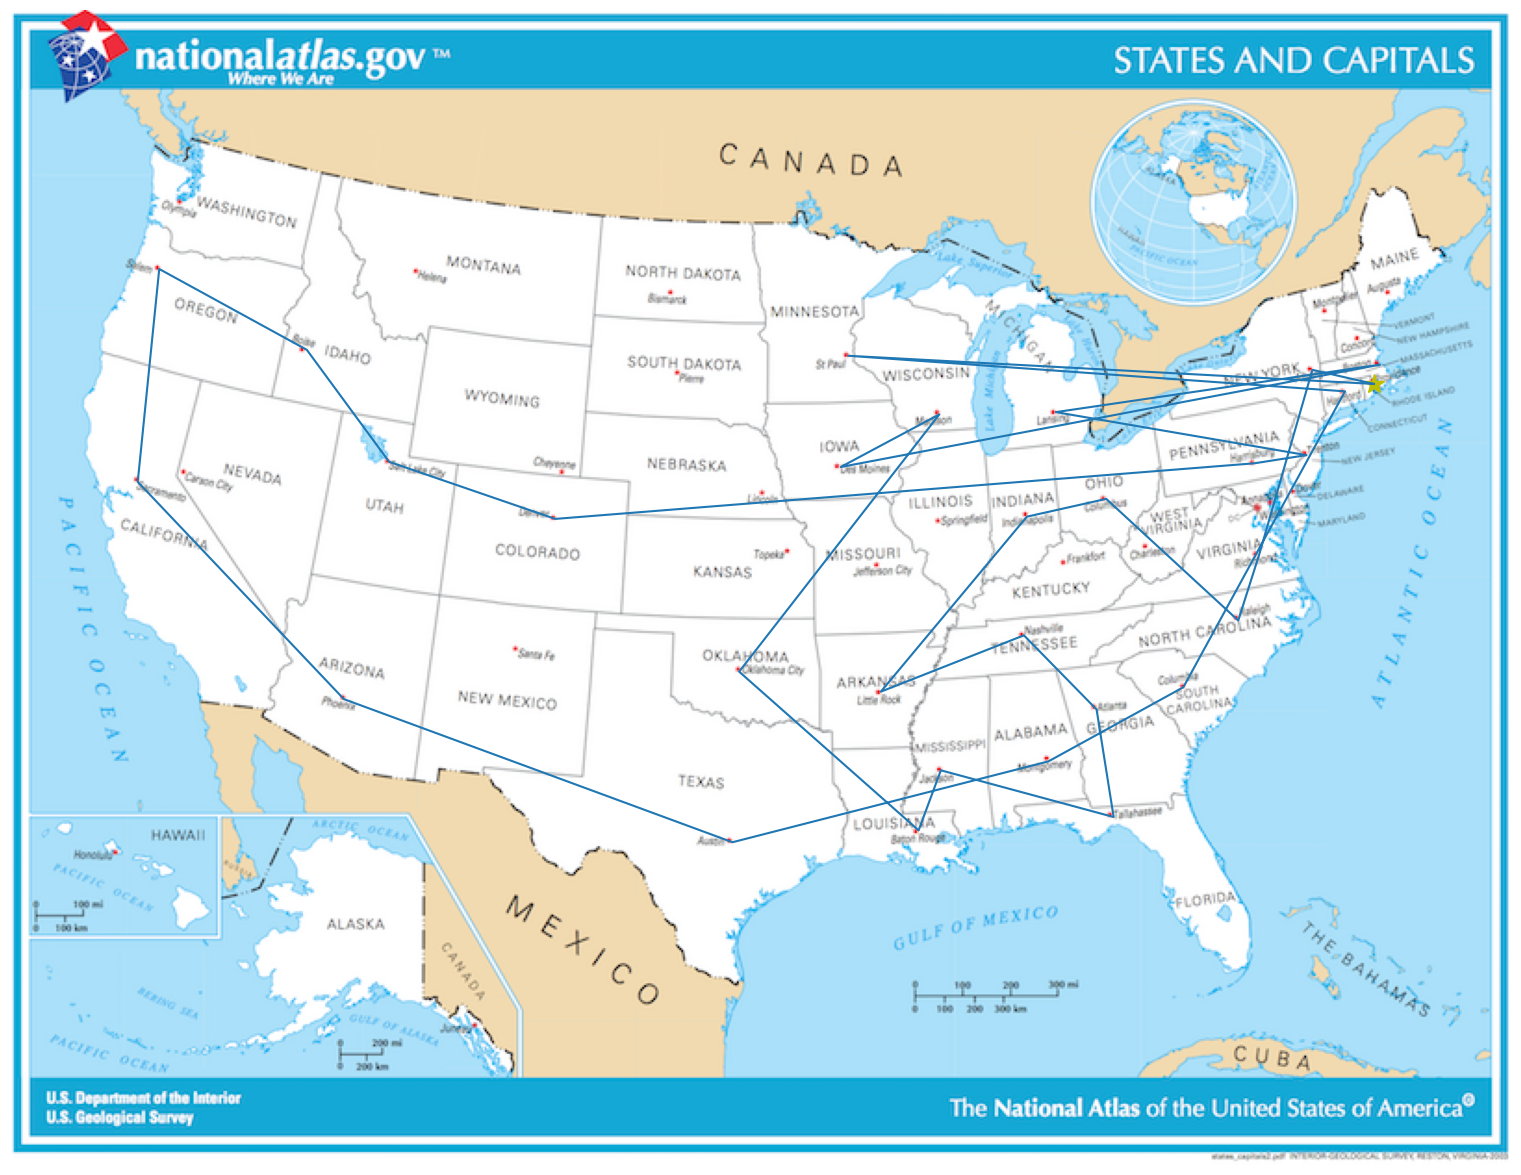

In [74]:
path = random_path(30,30)

final_distances, distance_space, times, new_path = annealing(path, time = 1000, alpha=0.97)
starting_city = new_path[0]

show_path(new_path, starting_city, w=35, h=15)

<Figure size 3000x1800 with 0 Axes>

Text(200, 4138.130477348661, '4138.13')

Text(200, 4414.613765869697, '4414.61')

Text(200, 3700.7960286428183, '3700.80')

Text(0.5, 1.0, 'Changing Acceptance')

Text(0.5, 0, 'Time')

Text(0, 0.5, 'Distance')

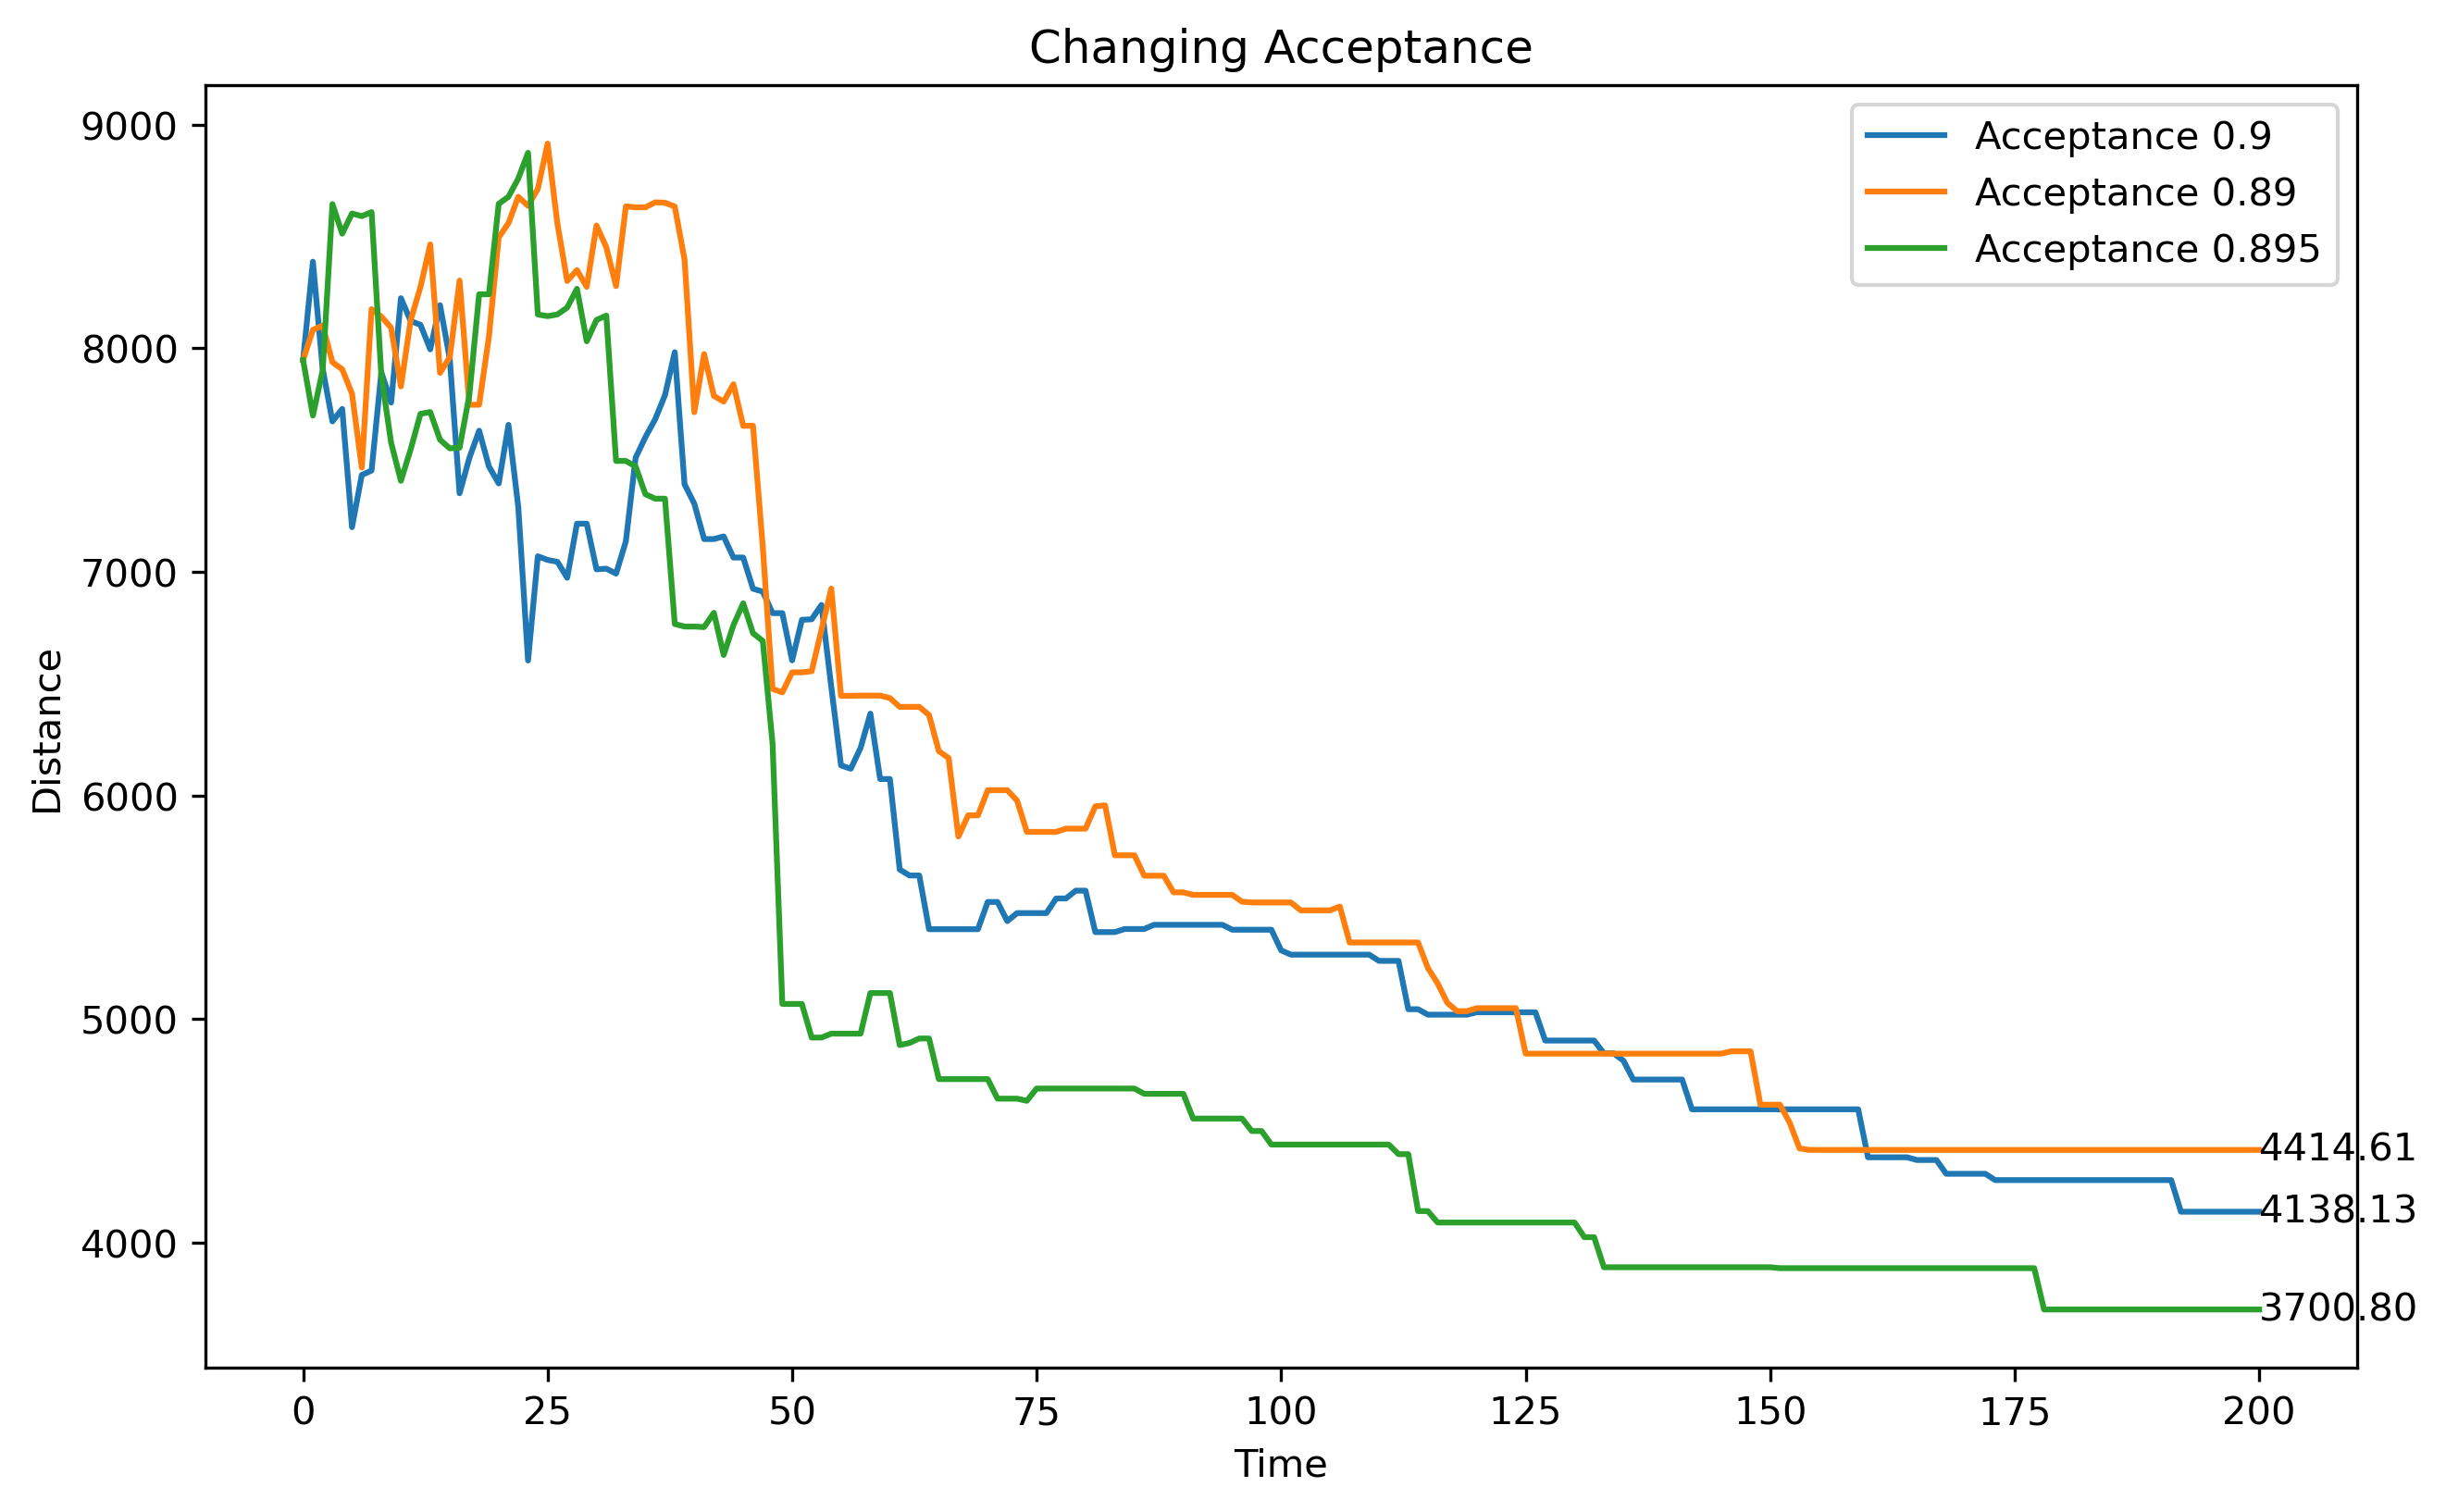

In [75]:
path = random_path(30, 30)

plt.figure(figsize=(10, 6), dpi=300)

acceptance = [0.9,0.89,0.895]

for i in acceptance:
    final_distance, distance_space, times, final_path = annealing(path, acceptance=i, time=200)
    plt.plot(times, distance_space, label='Acceptance {}'.format(i))
    plt.text(times[-1], distance_space[-1], '{:.2f}'.format(final_distance), ha='left', va='center')
    
plt.legend()
plt.title('Changing Acceptance')
plt.xlabel('Time')
plt.ylabel('Distance')
plt.show()


In [14]:
#Comments

#for a long time, the acceptance is the factor that determines convergence. For a lower accecptance p, the higher alpha is required to get the same level of convergence. This isnt suprising as higher alpha just makes the temperature schedules cool slower

## Problem 6 : Local minima and searching


Now that the algorithm is set, we want to obtain the absolute best path for all 30 capital cities. Repeat the simulated annealing 20 times with the optimal set of parameters that you have identified. 

Store for each attempt the best distance, and the optimal path. Propose a final solution to the problem, you can of course compare with the solutions obtained by other students but you should not be discussing your implementation or sharing or copying code.







In [ ]:
#doing PROBLEM 6

In [65]:
final_paths = []

for k in range(20):
    final_distance, distance_space, times, final_path = annealing(path, acceptance=0.97, time=200, N=30, alpha = 0.97)
    final_paths.append(final_path)

final_paths

[[('Columbus', (590.8, 263.2)),
  ('Columbus', (590.8, 263.2)),
  ('Raleigh', (662.0, 328.8)),
  ('Columbia', (632.4, 364.8)),
  ('Columbia', (632.4, 364.8)),
  ('Tallahassee', (594.8, 434.8)),
  ('Montgomery', (559.6, 404.8)),
  ('Austin', (389.2, 448.4)),
  ('Boise', (159.6, 182.8)),
  ('Salem', (80.0, 139.2)),
  ('Salem', (80.0, 139.2)),
  ('Madison', (500.8, 217.6)),
  ('Harrisburg', (670.8, 244.0)),
  ('Providence', (735.2, 201.2)),
  ('Boston', (738.4, 190.8)),
  ('Saint Paul', (451.6, 186.0)),
  ('Salem', (80.0, 139.2)),
  ('Indianapolis', (548.0, 272.8)),
  ('Columbus', (590.8, 263.2)),
  ('Indianapolis', (548.0, 272.8)),
  ('Providence', (735.2, 201.2)),
  ('Providence', (735.2, 201.2)),
  ('Raleigh', (662.0, 328.8)),
  ('Austin', (389.2, 448.4)),
  ('Phoenix', (179.6, 371.2)),
  ('Salt Lake City', (204.0, 243.2)),
  ('Phoenix', (179.6, 371.2)),
  ('Little Rock', (469.2, 367.2)),
  ('Little Rock', (469.2, 367.2)),
  ('Nashville', (546.4, 336.8))],
 [('Little Rock', (469.2, 367

In [ ]:
#the annealing algo causes repeats in the 'new path'

Text(0.5, 1.0, 'Changing Acceptance')

Text(0.5, 0, 'Time')

Text(0, 0.5, 'Distance')

Text(0.95, 0.9, 'Final Distance: 4293.20')

Text(0.95, 0.8, 'Final Distance: 4342.02')

Text(0.95, 0.7, 'Final Distance: 4344.25')

Text(0.95, 0.6, 'Final Distance: 3858.83')

Text(0.5, 1.0, 'Changing Alpha')

Text(0.5, 0, 'Time')

Text(0, 0.5, 'Distance')

/var/folders/k_/v2c53s_57fzdvynwxjpvjm0m0000gn/T/ipykernel_33449/1736668306.py:27: RuntimeWarning: overflow encountered in exp
  probability = np.exp(-(length_new - length_old) / temp)


Text(0.95, 0.9, 'Final Distance: 3688.29')

Text(0.95, 0.8, 'Final Distance: 4055.41')

Text(0.95, 0.7, 'Final Distance: 4167.98')

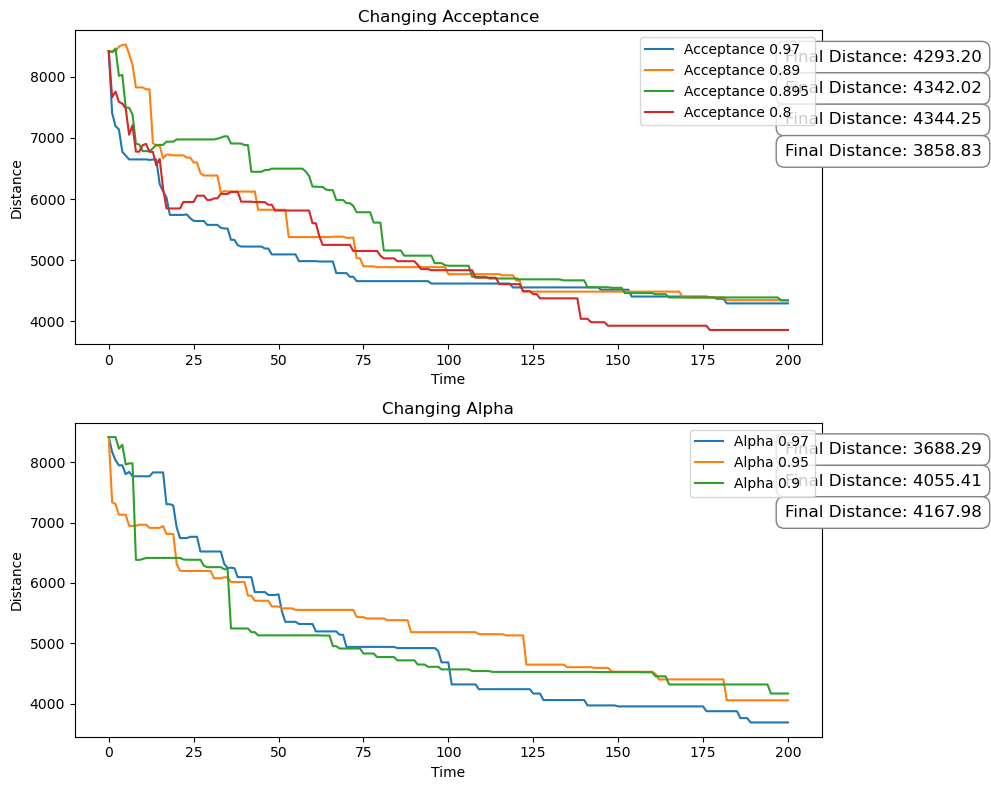

In [31]:
import matplotlib.pyplot as plt


# Create the figure and subplots
fig, axs = plt.subplots(2, 1, figsize=(10, 8))

# Subplot 1: Changing acceptance
axs[0].set_title('Changing Acceptance')
axs[0].set_xlabel('Time')
axs[0].set_ylabel('Distance')

acceptance_values = [0.97, 0.89, 0.895, 0.8]
final_distances_acceptance = []  # List to store final distances

for acceptance in acceptance_values:
    final_distance, distance_space, times, final_path = annealing(path, acceptance=acceptance, time=200, N=30)
    final_distances_acceptance.append(final_distance)
    axs[0].plot(times, distance_space, label='Acceptance {}'.format(acceptance))

# Add text boxes with the final distances
for i, distance in enumerate(final_distances_acceptance):
    axs[0].text(0.95, 0.9 - i * 0.1, 'Final Distance: {:.2f}'.format(distance),
                transform=axs[0].transAxes, fontsize=12, bbox=dict(facecolor='white', edgecolor='gray', boxstyle='round,pad=0.5'))

axs[0].legend()

# Subplot 2: Changing alpha
axs[1].set_title('Changing Alpha')
axs[1].set_xlabel('Time')
axs[1].set_ylabel('Distance')

alpha_values = [0.97, 0.95, 0.9]
final_distances_alpha = []  # List to store final distances

for alpha in alpha_values:
    final_distance, distance_space, times, final_path = annealing(path, alpha=alpha, time=200, N=30)
    final_distances_alpha.append(final_distance)
    axs[1].plot(times, distance_space, label='Alpha {}'.format(alpha))

# Add text boxes with the final distances
for i, distance in enumerate(final_distances_alpha):
    axs[1].text(0.95, 0.9 - i * 0.1, 'Final Distance: {:.2f}'.format(distance),
                transform=axs[1].transAxes, fontsize=12, bbox=dict(facecolor='white', edgecolor='gray', boxstyle='round,pad=0.5'))

axs[1].legend()

plt.tight_layout()  # Adjust the spacing between subplots
plt.show()

/var/folders/k_/v2c53s_57fzdvynwxjpvjm0m0000gn/T/ipykernel_16361/326654186.py:10: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = cm.get_cmap('coolwarm')


Text(0.5, 0, 'Time')

Text(0, 0.5, 'Distance')

Text(0.5, 1.0, 'Paths with Acceptance Gradient')

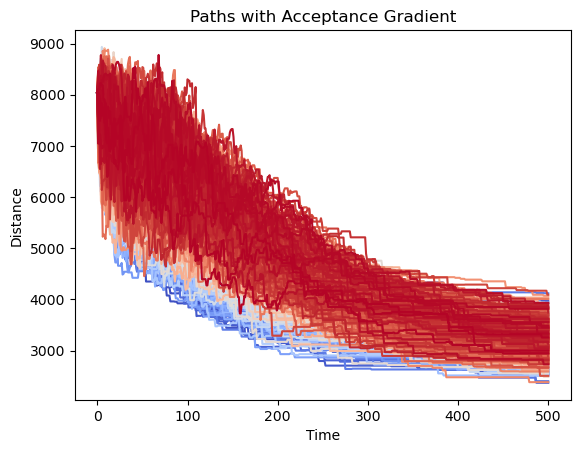

In [19]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm

ds = 1000
acceptance_values = np.linspace(0.85, 0.4, 1000)  # Generate 1000 acceptance values from 0.4 to 0.85
final_distances_acceptance = []  # List to store final distances

# Create a colormap
cmap = cm.get_cmap('coolwarm')

for timestep in range(ds):
    acceptance = acceptance_values[timestep]
    final_distance, distance_space, times = annealing(path, acceptance=acceptance, time=500, N=30, alpha = 0.99)
    final_distances_acceptance.append(final_distance)
    color = cmap(timestep / ds)  # Color based on the timestep

        
        
    # Plot the distance over time with the color gradient
    plt.plot(times, distance_space, color=color)

# Set the plot labels and title
plt.xlabel('Time')
plt.ylabel('Distance')
plt.title('Paths with Acceptance Gradient')

plt.show()

#the redder colours indicate ealier timesteps i.e lower accecptance values, whilst the blue colours represent higher acceptance


## Open questions

We propose here a set of open-ended questions, which will provide opportunities to expand the discussion in your report. 


0. How can you find the longest path instead of the shortest path, explain your idea

0. Explain why the cooling procedure and temperature schedule is key to the success of the minimisation

0. Imagine that we now slightly complicate the question: Travelling coast-to-coast is difficult in winter time, due to frequent road closures in the central states (snow conditions). How could you modify the algorithm such that we avoid as much as possible crossing the country transversally ?

0. Comment briefly on possible other scientific topics where simulated annealing could be useful, and provide one or two references
 


Answers : 
    
    
    .......
    
    
    .......
    
    
    .......

In [86]:

def temperature(time, alpha = 0.97, T_0 = 1e+3):
    
    T = (alpha**time)*T_0
    
    return T

def random_path(N, cities = 30):

    sequence = np.random.choice(range(0,cities), N, replace = False) #generates a list of N random integers between 0 and cities inclusive with no repeats
    path = []
    
    for k in sequence:
        path.append(capitals_list[k])

        
    return path

def swap(path):
    
    clone = path.copy()
    index1, index2 = np.random.choice(range(0, len(path)),2, replace = False)
    clone[index2] , clone[index1] = path[index1] , path[index2]

    return clone


In [118]:
def bias_path_finder(path, bias):

    consecutives = list(zip(path, path[1:])) #connecting consecutive cities in tuples
    consecutives.append((consecutives[-1][1],consecutives[0][0])) #connecting final city to initial city (making len(consecutives) = len(path)+1)
    
    distance = 0
    for i in range(len(consecutives)):
        P, Q = coords(consecutives[i])
 
        distance += np.sqrt( (Q[0] - P[0])**2 + ((Q[1] - P[1])**2)*bias) #bias term should be less than one

        
    return distance



def transvese_avoidance(path = None, N=8, T_0 = 1e+3, alpha = 0.97, time = 200, bias = 0.95):
    
    if path != None: pass #preliminary code to check if a path was parsed, if not one is generated based on user controlled N
    
    else: path = random_path(N)
    
    old_distance = bias_path_finder(path, bias)#initial values
    T=T_0
    
    
    #plotting purposes
    solution_space = np.zeros(time+1) ; solution_space[0] = old_distance 
    cooling_schedule = [temperature(time, alpha, T_0) for time in range(time+1)]
    
    for dt in range(time):
        
        new_path = swap(path) 
        new_distance = bias_path_finder(new_path, bias)
        
        
        P = np.exp(-(new_distance - old_distance) / T)
        
        if P >= np.random.random(): #accepted case
            
            path , T, old_distance, solution_space[dt+1] = new_path, temperature(dt, alpha , T_0), new_distance, new_distance
            
        else: T, solution_space[dt+1] = temperature(dt, alpha, T_0), old_distance
            
            
            
            
    return old_distance, path, solution_space, cooling_schedule


/var/folders/k_/v2c53s_57fzdvynwxjpvjm0m0000gn/T/ipykernel_33449/1181487206.py:37: RuntimeWarning: overflow encountered in exp
  P = np.exp(-(new_distance - old_distance) / T)


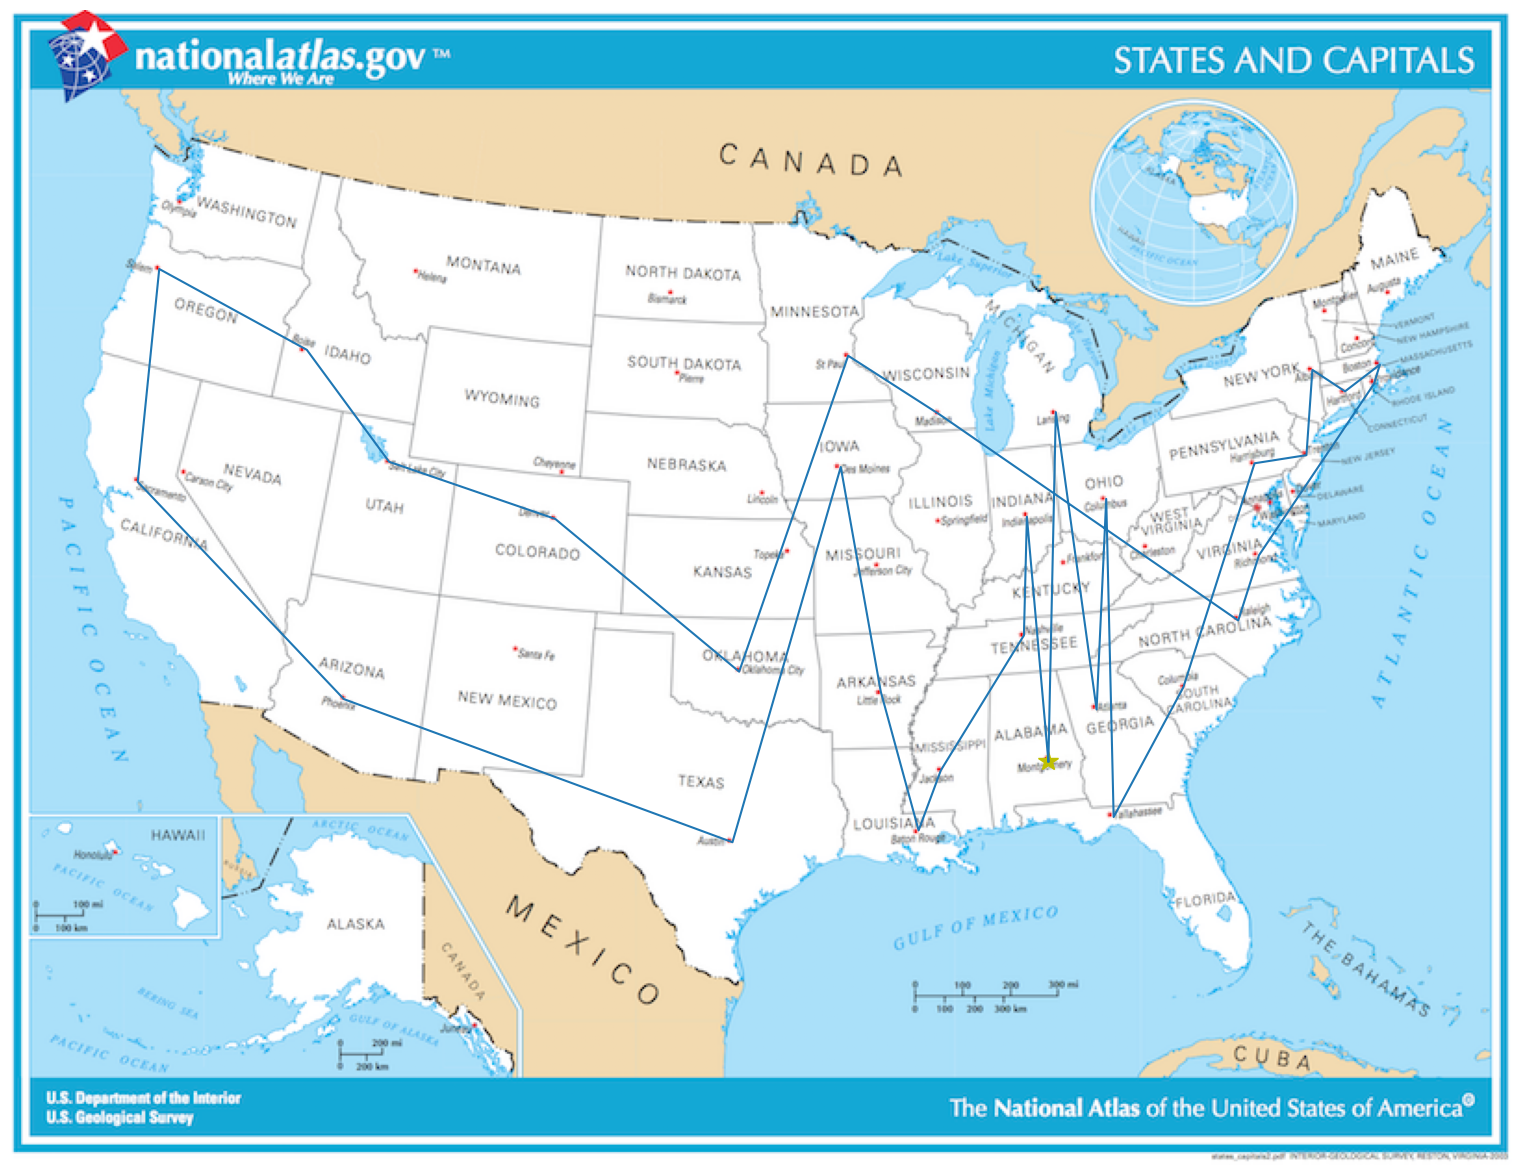

In [126]:
path7 = random_path(30)
finaldistance,pathk,solution_space,cooling_schedule = transvese_avoidance(path7, T_0 = 1e+5, alpha = 0.98, time =10000, bias=0.000001)
show_path(pathk, pathk[0], w=35, h=15)

In [127]:
finaldistance

1340.0146687124966